In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 43.08 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi",
)
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ]
)
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
# Set the batch size
BATCH_SIZE = (
    32  # this is lower than the ViT paper but it's because we're starting small
)

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,  # use manually created transforms
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78d4f361f110>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

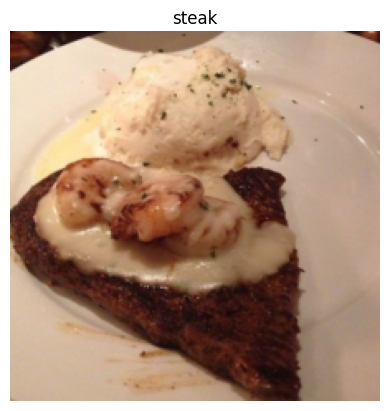

In [8]:
plt.imshow(
    image.permute(1, 2, 0)
)  # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

In [ ]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width) / patch_size**2)

In [ ]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(embedding_layer_input_shape)
print(embedding_layer_output_shape)

(224, 224, 3)
(196, 768)


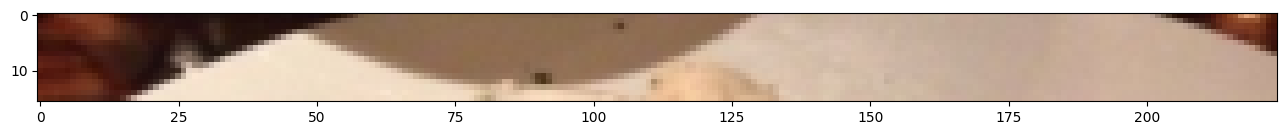

In [11]:
image_permuted = image.permute(1, 2, 0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:16, :, :])

In [ ]:
def patchifying(img):
    img_size = 224
    patch_size = 16
    image_permuted = img.permute(1, 2, 0)

    fig, axs = plt.subplots(
        nrows=img_size // patch_size,
        ncols=img_size // patch_size,
        sharex=True,
        sharey=True,
    )

    counter = 0
    next_patch_size_length = patch_size
    while next_patch_size_length <= image_permuted.shape[0]:
        next_patch_size_width = patch_size
        while next_patch_size_width <= image_permuted.shape[1]:
            ax = axs.flat[counter]
            ax.imshow(
                image_permuted[
                    next_patch_size_length - patch_size:next_patch_size_length,
                    next_patch_size_width - patch_size:next_patch_size_width,
                    :,
                ]
            )
            ax.set_xlabel(counter + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            next_patch_size_width += patch_size
            counter += 1
        next_patch_size_length += patch_size


In [ ]:
# patchifying(image)

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, channel_size=3, patch_size=16, embed_dim=768) -> None:
        super().__init__()

        self.patch_size = patch_size
        self.channel_size = channel_size
        self.embed_dim = embed_dim

        self.conv = nn.Conv2d(
            in_channels=channel_size,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )
        self.flattening = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        b, c, h, w = x.shape
        assert c == self.channel_size, f"Expected {self.channel_size} channels, got {c}"
        assert h % self.patch_size == 0 and w % self.patch_size == 0, "Image size not divisible by patch size"

        patches = self.conv(x)  # [B, embed_dim, H/patch, W/patch]
        patches = self.flattening(patches).transpose(1, 2)  # [B, num_patches, embed_dim]
        return patches

In [15]:
model = PatchEmbedding()
patch_embedded_image = model(image.unsqueeze(0))

In [16]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [17]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [18]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)

In [19]:
class_token.shape

torch.Size([1, 1, 768])

In [20]:
patch_embedded_image_with_class_embedding = torch.cat(
    (class_token, patch_embedded_image), dim=1
)

In [21]:
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [22]:
patch_embedded_image_with_class_embedding

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0153, -0.1934,  0.1537,  ..., -0.0396, -0.0858,  0.0840],
         [ 0.1289, -0.4735,  0.2011,  ..., -0.1761, -0.4182,  0.1318],
         ...,
         [ 0.1227, -0.4824,  0.3409,  ..., -0.0123, -0.1484,  0.0593],
         [ 0.1552, -0.5471,  0.3697,  ..., -0.0105, -0.1734,  0.0662],
         [ 0.1169, -0.6175,  0.3728,  ...,  0.0218, -0.2095,  0.0869]]],
       grad_fn=<CatBackward0>)

In [23]:
number_of_patches = int((height * width) / patch_size**2)

embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

position_embedding = nn.Parameter(
    torch.ones(1, number_of_patches + 1, embedding_dimension), requires_grad=True
)  

In [24]:
set_seeds()
patch_size = 16
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(
    channel_size=3, patch_size=patch_size, embed_dim=768
)
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension), requires_grad=True
) 
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(
    torch.ones(1, number_of_patches + 1, embedding_dimension), requires_grad=True
) 

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [28]:
# patch_and_position_embedding_normalized = nn.LayerNorm(patch_and_position_embedding)

class MutliSelfAttentionBlock(nn.Module):

    def __init__(self, D=768, nhead=3):
        super().__init__()
        self.layer_norm = nn.LayerNorm(
            normalized_shape=D, eps=1e-5, elementwise_affine=True
        )
        self.attn = nn.MultiheadAttention(D, nhead, dropout=0.1, batch_first=True)

    def forward(self, x):
        return self.attn(self.layer_norm(x), self.layer_norm(x), self.layer_norm(x))

model = MutliSelfAttentionBlock()

In [29]:
model(patch_and_position_embedding)

(tensor([[[ 0.3960, -0.0740,  0.7359,  ...,  0.1581,  0.5255,  0.1834],
          [ 0.3965, -0.0756,  0.7511,  ...,  0.1523,  0.5311,  0.1887],
          [ 0.3945, -0.0715,  0.7523,  ...,  0.1428,  0.5213,  0.1771],
          ...,
          [ 0.4033, -0.0816,  0.7463,  ...,  0.1746,  0.5193,  0.2110],
          [ 0.3603, -0.0640,  0.7020,  ...,  0.1487,  0.5258,  0.1855],
          [ 0.4071, -0.0802,  0.7606,  ...,  0.1636,  0.5237,  0.2017]]],
        grad_fn=<TransposeBackward0>),
 tensor([[[0.0038, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0038],
          [0.0053, 0.0049, 0.0034,  ..., 0.0039, 0.0058, 0.0039],
          [0.0030, 0.0051, 0.0028,  ..., 0.0057, 0.0038, 0.0057],
          ...,
          [0.0051, 0.0050, 0.0043,  ..., 0.0057, 0.0057, 0.0039],
          [0.0067, 0.0015, 0.0043,  ..., 0.0057, 0.0038, 0.0057],
          [0.0069, 0.0036, 0.0044,  ..., 0.0038, 0.0057, 0.0038]]],
        grad_fn=<MeanBackward1>))